## Exploring Strategies with Distributed Data

1. Work with **all** of the data with **spark**

    \+ most accurate reports    
    \- limited by the operations that spark provides, e.g. visualization. 


2. Work with a **sample** of the data with **pandas**

    \+ This lets us use the tools we are already familiar with to explore the data  
    \+ More visualization options  
    \+ Faster iteration   
    \- We are working with a sample, and not the entire data, so we could be missing information.  


3. **Aggregate** the data with **spark**, and then work with the aggregated data locally with **Pandas**

    \+ We won't "miss out" on anything like we have the potential to do when working with sampled data  
    \+ Benefits of working locally in the pandas ecosystem   
    \- However, we are limited by the fact that we have to do aggregation, which usually results in a different shape of data, and information is lost when aggregating.  

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                


## Strategy 1: Work with all the data using Spark

#### How many open and closed cases are there?


In [3]:
sdf = df

In [4]:
sdf.groupBy('case_status').count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



#### What is the average amount of time a case is open?

In [8]:
sdf.groupBy('case_status').agg(mean('case_lifetime')).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



## Strategy 2: Work with a sample of the data with Pandas

In [9]:
pdf = df

In [13]:
pdf = sdf.sample(fraction=0.2, seed=42).toPandas()

In [14]:
pdf.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127348,2018-01-01 07:05:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.706007,True,Front Or Side Yard Parking,16.058646,Closed,svcCRMSS,"834 BARREL POINT, San Antonio, 78251",004,-2.100858,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127350,2018-01-01 07:06:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.705764,True,Front Or Side Yard Parking,16.057755,Closed,svcCRMSS,"834 BARREL POINT, San Antonio, 78251",004,-2.100823,78251,219,1.0,1,DSD/Code Enforcement,True
3,1014127358,2018-01-01 07:12:00,2018-01-02 15:35:00,2018-01-17 08:30:00,False,-14.704699,True,Right Of Way/Sidewalk Obstruction,16.054063,Closed,svcCRMSS,"837 BARREL POINT, San Antonio, 78251",004,-2.100671,78251,219,1.0,1,DSD/Code Enforcement,True
4,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True


In [15]:
pdf.shape

(169047, 20)

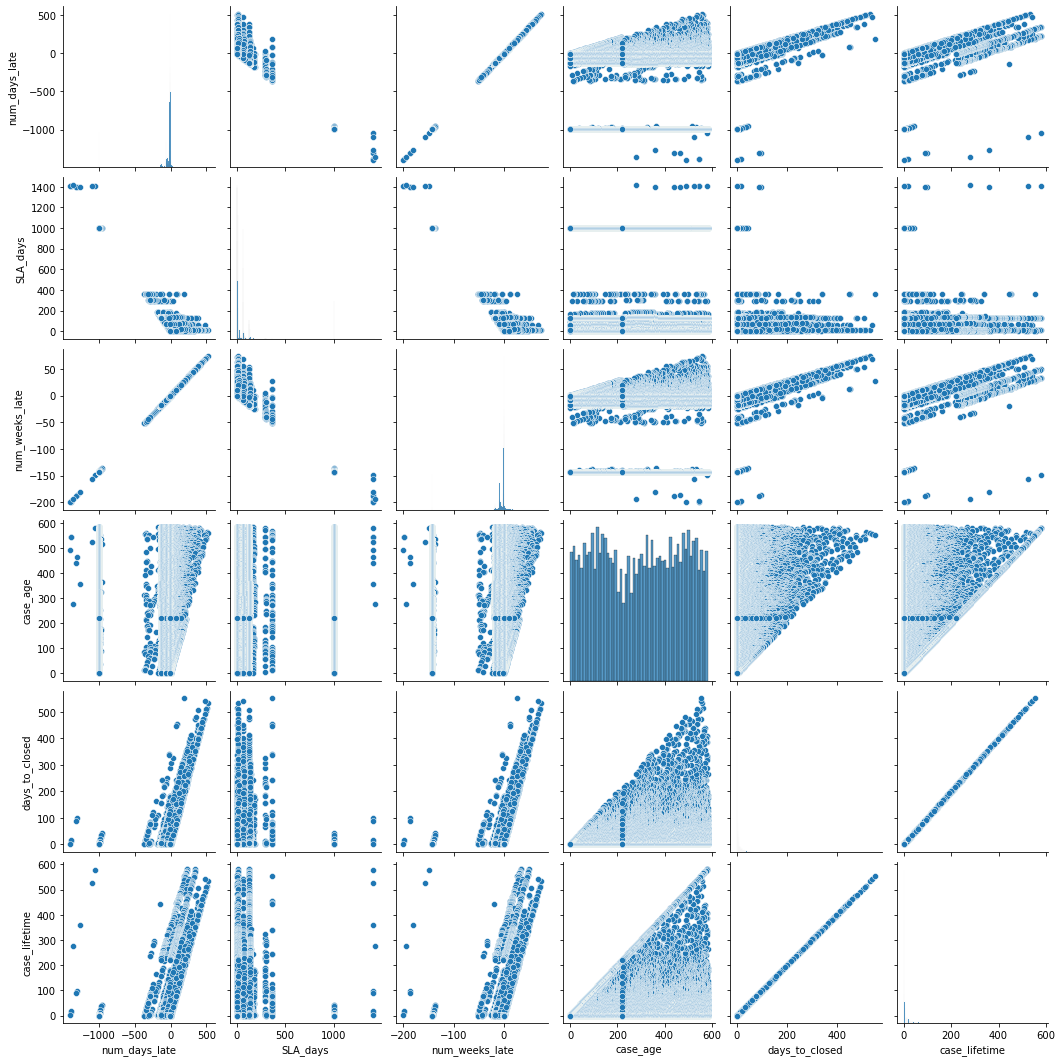

In [19]:
# numeric columns
numeric_cols = ['num_days_late', 'SLA_days', 'num_weeks_late', 'case_age', 'days_to_closed', 'case_lifetime']

# pairplot of numberis columns
sns.pairplot(pdf[numeric_cols])

#### Explore one variable: Are some departments more likely to have late cases than others

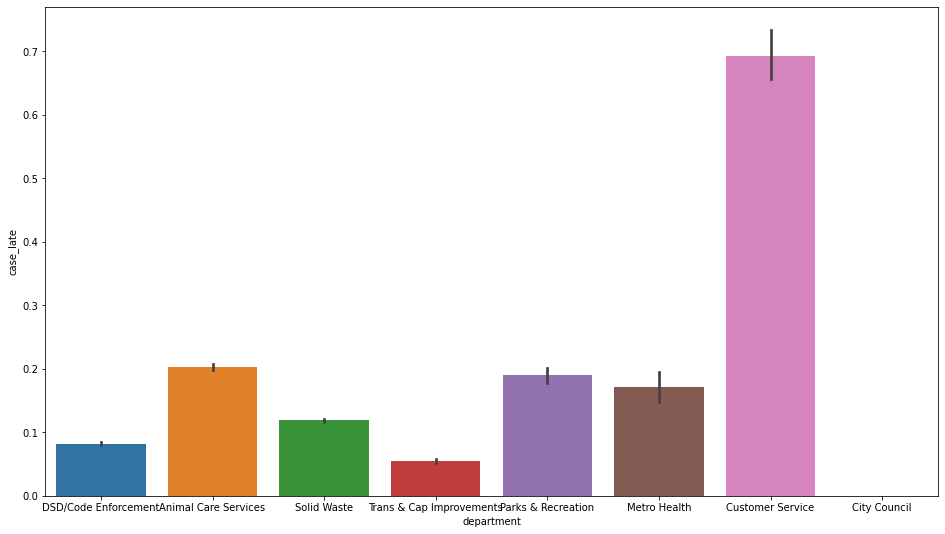

In [22]:
# case late by department
plt.figure(figsize=(16, 9))

sns.barplot(pdf.department, pdf.case_late)
plt.show()

#### Change seed see if we ger similar results

In [23]:
pdf_s2 = sdf.sample(fraction=0.2, seed=1337).toPandas()

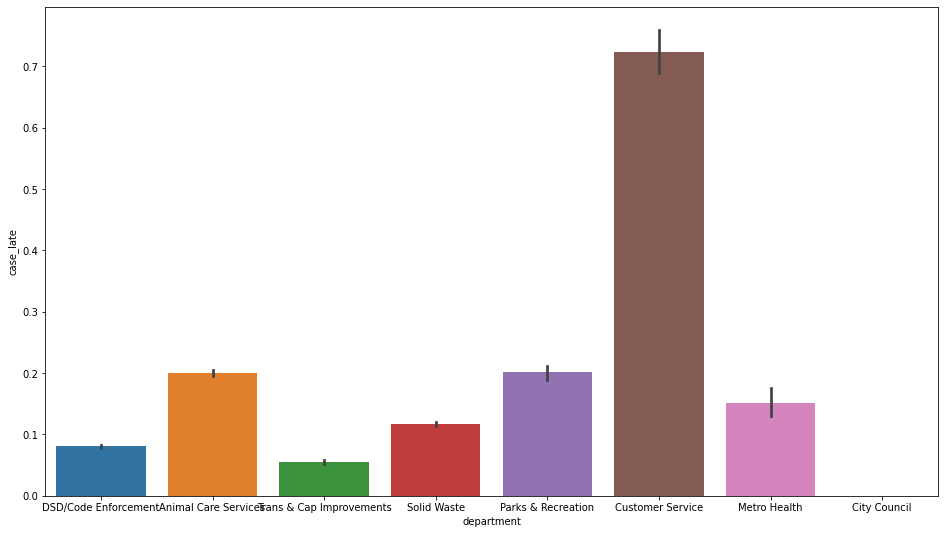

In [24]:
plt.figure(figsize=(16, 9))

sns.barplot(pdf_s2.department, pdf_s2.case_late)
plt.show()

## Strategy 3: Aggregate with spark, and then work with the aggregated data using Pandas

#### Which Department has the most cases?


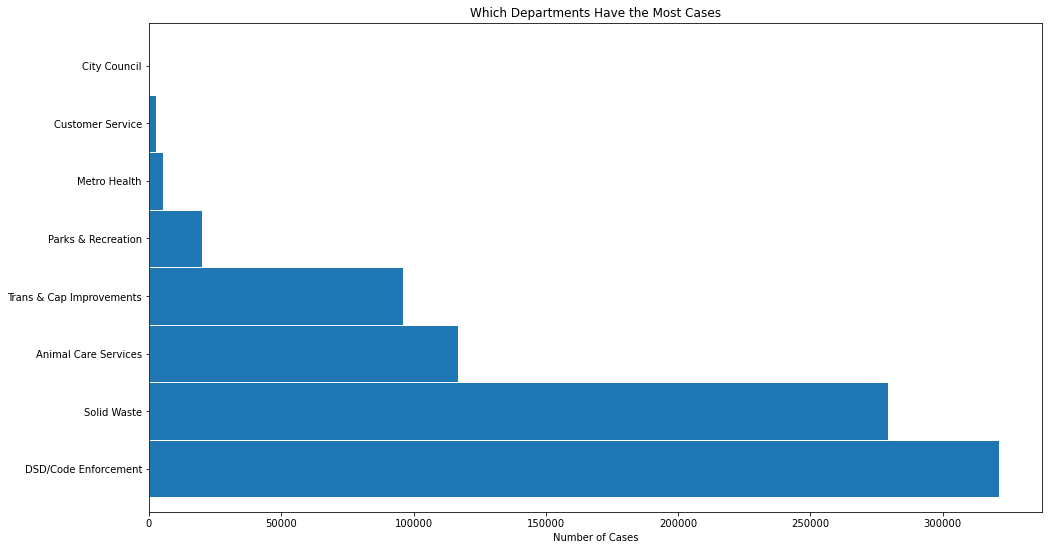

In [29]:
# aggregate in spark

(
    sdf.groupBy('department')
    .count()
    .toPandas()
    .set_index('department')['count']
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='white', figsize=(16,9))
    
)

plt.title("Which Departments Have the Most Cases")
plt.xlabel('Number of Cases')
plt.ylabel('')
plt.show()

#### What does the case lifetime look like for each department?

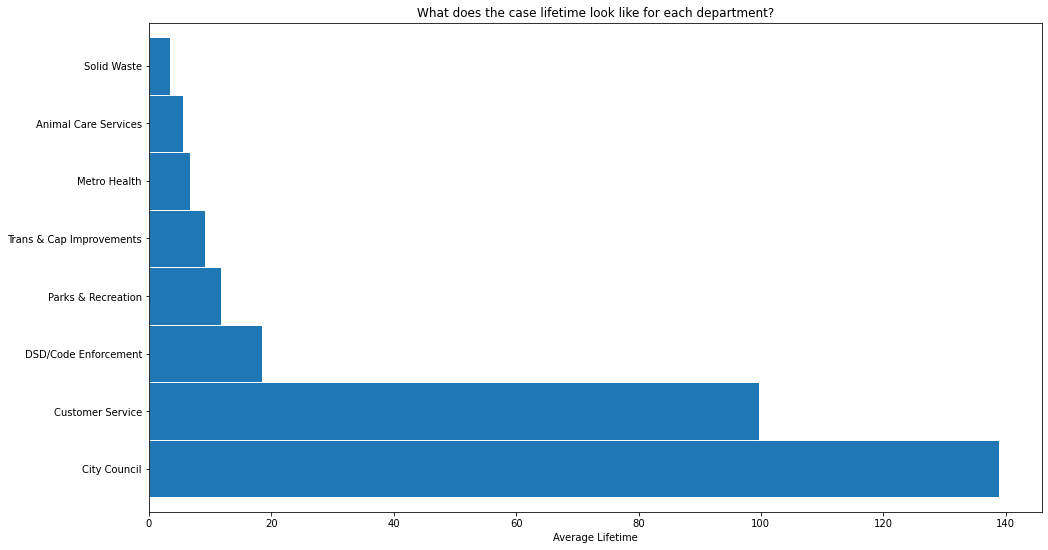

In [48]:
(
    sdf.groupBy('department')
    .agg(mean('case_lifetime').alias('mean_lifetime'))
    .toPandas()
    .set_index('department')
    .mean_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='white', figsize=(16,9))
)

plt.title("What does the case lifetime look like for each department?")
plt.xlabel('Average Lifetime')
plt.ylabel('')
plt.show()

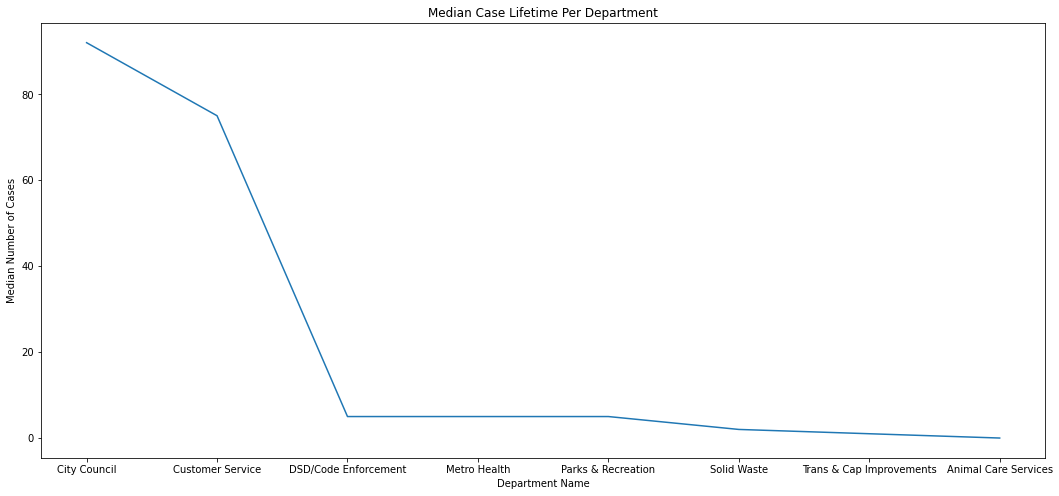

In [71]:
import pyspark.sql.functions as F

plt.figure(figsize=(18,8))

( 
    sdf.groupBy('department')
     .agg(F.expr('percentile({} , array(0.50))'.format('case_lifetime'))[0].alias('median_case_lifetime'))
    #convert to pandas
     .toPandas().set_index('department')
     .median_case_lifetime.sort_values(ascending=False).plot()
 
)

plt.title('Median Case Lifetime Per Department')
plt.ylabel("Median Number of Cases")
plt.xlabel('Department Name')

plt.show()

In [73]:
sdf.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [77]:
(
    sdf.groupBy('department')
    .agg(mean('case_lifetime').alias('mean_lifetime'))
    .agg(F.expr('percentile({} , array(0.50))'.format('case_lifetime'))[0].alias('median_case_lifetime'))
    
).show()


AnalysisException: cannot resolve '`case_lifetime`' given input columns: [department, mean_lifetime]; line 1 pos 11;
'Aggregate ['percentile('case_lifetime, array(0.50))[0] AS median_case_lifetime#2625]
+- Aggregate [department#371], [department#371, avg(cast(case_lifetime#242 as bigint)) AS mean_lifetime#2622]
   +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, department#371, (dept_subject_to_SLA#281 = YES) AS dept_subject_to_SLA#392]
      +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, standardized_dept_name#280 AS department#371, dept_subject_to_SLA#281]
         +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, standardized_dept_name#280, dept_subject_to_SLA#281]
            +- Project [dept_division#23, case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, standardized_dept_name#280, dept_subject_to_SLA#281]
               +- Project [dept_division#23, case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, dept_name#279, standardized_dept_name#280, dept_subject_to_SLA#281]
                  +- Project [dept_division#23, case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, dept_name#279, standardized_dept_name#280, dept_subject_to_SLA#281]
                     +- Join LeftOuter, (dept_division#23 = dept_division#278)
                        :- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, CASE WHEN NOT case_closed#59 THEN case_age#205 ELSE days_to_closed#223 END AS case_lifetime#242]
                        :  +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, datediff(cast(case_closed_date#119 as date), cast(case_opened_date#104 as date)) AS days_to_closed#223]
                        :     +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, datediff(cast(1533742680000000 as date), cast(case_opened_date#104 as date)) AS case_age#205]
                        :        +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, regexp_extract(request_address#28, \d+$, 0) AS zipcode#188]
                        :           +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, format_string(%03d, cast(council_district#89 as int)) AS council_district#172, num_weeks_late#156]
                        :              +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89, (num_days_late#21 / cast(7 as double)) AS num_weeks_late#156]
                        :                 +- Project [case_id#16, case_opened_date#104, case_closed_date#119, to_timestamp('case_due_date, Some(M/d/yy H:mm)) AS case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89]
                        :                    +- Project [case_id#16, case_opened_date#104, to_timestamp('case_closed_date, Some(M/d/yy H:mm)) AS case_closed_date#119, case_due_date#44, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89]
                        :                       +- Project [case_id#16, to_timestamp('case_opened_date, Some(M/d/yy H:mm)) AS case_opened_date#104, case_closed_date#18, case_due_date#44, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89]
                        :                          +- Project [case_id#16, case_opened_date#17, case_closed_date#18, case_due_date#44, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, cast(council_district#29 as string) AS council_district#89]
                        :                             +- Project [case_id#16, case_opened_date#17, case_closed_date#18, case_due_date#44, (case_late#20 = YES) AS case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29]
                        :                                +- Project [case_id#16, case_opened_date#17, case_closed_date#18, case_due_date#44, case_late#20, num_days_late#21, (case_closed#22 = YES) AS case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29]
                        :                                   +- Project [case_id#16, case_opened_date#17, case_closed_date#18, SLA_due_date#19 AS case_due_date#44, case_late#20, num_days_late#21, case_closed#22, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29]
                        :                                      +- Relation[case_id#16,case_opened_date#17,case_closed_date#18,SLA_due_date#19,case_late#20,num_days_late#21,case_closed#22,dept_division#23,service_request_type#24,SLA_days#25,case_status#26,source_id#27,request_address#28,council_district#29] csv
                        +- Relation[dept_division#278,dept_name#279,standardized_dept_name#280,dept_subject_to_SLA#281] csv


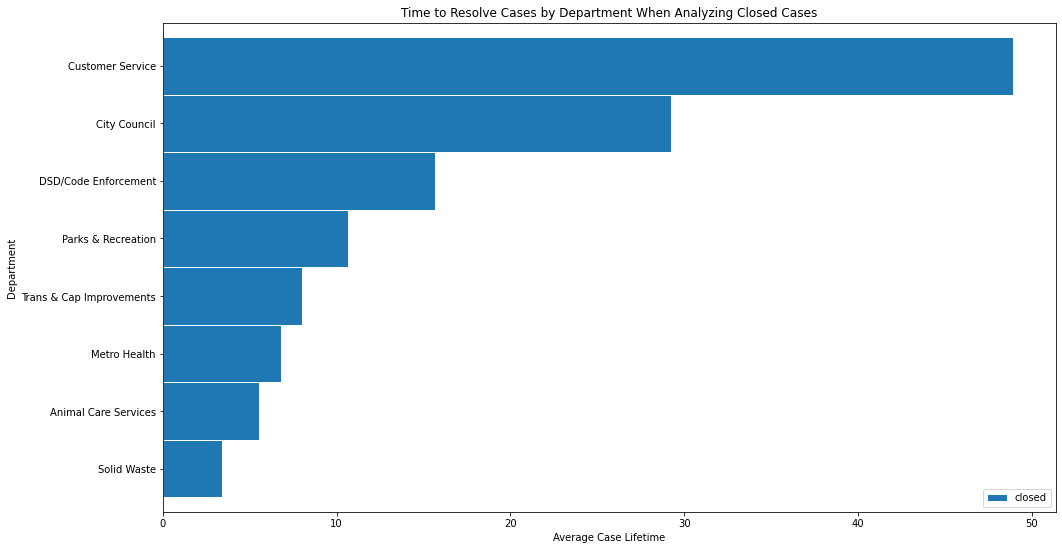

In [51]:
(
    sdf.groupBy('department')
    .pivot('case_status')
    .agg(round(mean('case_lifetime'), 2))
    .orderBy('Closed')
    .select('department', 'closed')
    .toPandas()
    .set_index('department')
    .plot.barh(width=1, edgecolor='white', figsize=(16,9))
)

plt.title("Time to Resolve Cases by Department When Analyzing Closed Cases")
plt.xlabel('Average Case Lifetime')
plt.ylabel('Department')
plt.show()

In [59]:
cases_by_day = sdf.select(
    'department',
    date_format('case_opened_date', 
              'yyyy-MM-dd').alias('case_opened'),
    date_format('case_closed_date', 
              'yyyy-MM-dd').alias('case_closed')
)

In [60]:
cases_by_day.show(3)

+--------------------+-----------+-----------+
|          department|case_opened|case_closed|
+--------------------+-----------+-----------+
|Animal Care Services| 2018-01-01| 2018-01-01|
|Trans & Cap Impro...| 2018-01-01| 2018-01-03|
|Trans & Cap Impro...| 2018-01-01| 2018-01-02|
+--------------------+-----------+-----------+
only showing top 3 rows



In [61]:
# cases_opened = ()

(
    cases_by_day
    .groupBy('case_opened')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()

)

AnalysisException: cannot resolve '`case_opened_date`' given input columns: [case_opened, count];
'Sort ['case_opened_date ASC NULLS FIRST], true
+- Filter AtLeastNNulls(n, case_opened#2190,count#2217L)
   +- Aggregate [case_opened#2190], [case_opened#2190, count(1) AS count#2217L]
      +- Project [department#371, date_format(case_opened_date#104, yyyy-MM-dd, Some(America/Chicago)) AS case_opened#2190, date_format(case_closed_date#119, yyyy-MM-dd, Some(America/Chicago)) AS case_closed#2191]
         +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, department#371, (dept_subject_to_SLA#281 = YES) AS dept_subject_to_SLA#392]
            +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, standardized_dept_name#280 AS department#371, dept_subject_to_SLA#281]
               +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, standardized_dept_name#280, dept_subject_to_SLA#281]
                  +- Project [dept_division#23, case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, standardized_dept_name#280, dept_subject_to_SLA#281]
                     +- Project [dept_division#23, case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, dept_name#279, standardized_dept_name#280, dept_subject_to_SLA#281]
                        +- Project [dept_division#23, case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, case_lifetime#242, dept_name#279, standardized_dept_name#280, dept_subject_to_SLA#281]
                           +- Join LeftOuter, (dept_division#23 = dept_division#278)
                              :- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, days_to_closed#223, CASE WHEN NOT case_closed#59 THEN case_age#205 ELSE days_to_closed#223 END AS case_lifetime#242]
                              :  +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, case_age#205, datediff(cast(case_closed_date#119 as date), cast(case_opened_date#104 as date)) AS days_to_closed#223]
                              :     +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, zipcode#188, datediff(cast(1533742680000000 as date), cast(case_opened_date#104 as date)) AS case_age#205]
                              :        +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#172, num_weeks_late#156, regexp_extract(request_address#28, \d+$, 0) AS zipcode#188]
                              :           +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, format_string(%03d, cast(council_district#89 as int)) AS council_district#172, num_weeks_late#156]
                              :              +- Project [case_id#16, case_opened_date#104, case_closed_date#119, case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89, (num_days_late#21 / cast(7 as double)) AS num_weeks_late#156]
                              :                 +- Project [case_id#16, case_opened_date#104, case_closed_date#119, to_timestamp('case_due_date, Some(M/d/yy H:mm)) AS case_due_date#134, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89]
                              :                    +- Project [case_id#16, case_opened_date#104, to_timestamp('case_closed_date, Some(M/d/yy H:mm)) AS case_closed_date#119, case_due_date#44, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89]
                              :                       +- Project [case_id#16, to_timestamp('case_opened_date, Some(M/d/yy H:mm)) AS case_opened_date#104, case_closed_date#18, case_due_date#44, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#89]
                              :                          +- Project [case_id#16, case_opened_date#17, case_closed_date#18, case_due_date#44, case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, cast(council_district#29 as string) AS council_district#89]
                              :                             +- Project [case_id#16, case_opened_date#17, case_closed_date#18, case_due_date#44, (case_late#20 = YES) AS case_late#74, num_days_late#21, case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29]
                              :                                +- Project [case_id#16, case_opened_date#17, case_closed_date#18, case_due_date#44, case_late#20, num_days_late#21, (case_closed#22 = YES) AS case_closed#59, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29]
                              :                                   +- Project [case_id#16, case_opened_date#17, case_closed_date#18, SLA_due_date#19 AS case_due_date#44, case_late#20, num_days_late#21, case_closed#22, dept_division#23, service_request_type#24, SLA_days#25, case_status#26, source_id#27, request_address#28, council_district#29]
                              :                                      +- Relation[case_id#16,case_opened_date#17,case_closed_date#18,SLA_due_date#19,case_late#20,num_days_late#21,case_closed#22,dept_division#23,service_request_type#24,SLA_days#25,case_status#26,source_id#27,request_address#28,council_district#29] csv
                              +- Relation[dept_division#278,dept_name#279,standardized_dept_name#280,dept_subject_to_SLA#281] csv
